In [61]:
import keras
import tensorflow as tf
from keras import layers, models, optimizers
import matplotlib.pyplot as plt
import numpy as np

# Prepare data

We'll use images from two directories: `monet` and `photo`. The `monet` directory contains paintings by Claude Monet, while the `photo` directory contains photographs of the same scenes. The goal is to train a neural network to transform a photograph into a Monet-style painting.


In [62]:
BATCH_SIZE = 32
EPOCHS = 100

Shape of image: (256, 256, 3)


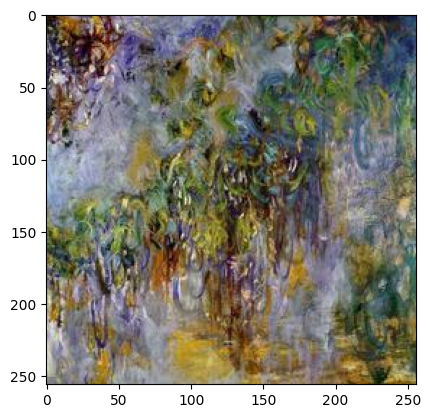

In [63]:
from matplotlib.image import imread
image = imread("../data/gan-getting-started/monet_jpg/0a5075d42a.jpg")
print("Shape of image:", image.shape)
plt.imshow(image)
plt.show()

In [64]:
dataset_monet = keras.utils.image_dataset_from_directory("../data/gan-getting-started/monet_jpg",label_mode=None, image_size=(256, 256), batch_size=BATCH_SIZE)

Found 300 files belonging to 1 classes.


Shape of image: (256, 256, 3)


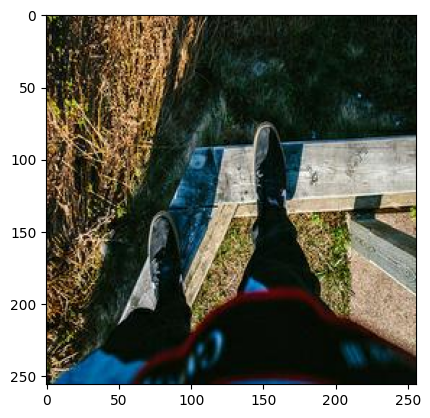

In [65]:
from matplotlib.image import imread
image = imread("../data/gan-getting-started/photo_jpg/00c6a0ad1e.jpg")
print("Shape of image:", image.shape)
plt.imshow(image)
plt.show()

In [66]:
dataset_photo = keras.utils.image_dataset_from_directory("../data/gan-getting-started/photo_jpg",label_mode=None, image_size=(256, 256), batch_size=BATCH_SIZE)

Found 7038 files belonging to 1 classes.


In [67]:
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1.0
    return image

dataset_monet = dataset_monet.map(preprocess)
dataset_photo = dataset_photo.map(preprocess)

# Create the discriminator

The discriminator is a convolutional neural network (CNN) that classifies images as real or fake. It takes an image as input and outputs a probability that the image is real (from the dataset) or fake (generated by the generator). The discriminator is trained to maximize the probability of correctly classifying real and fake images.

In [68]:
discriminator = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    layers.Conv2D(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(16, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
],
name="discriminator")
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 128, 128, 64)      0         
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 16)        16400     
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 64, 64, 16)        0         
                                                                 
 flatten_3 (Flatten)         (None, 65536)             0         
                                                                 
 dropout_3 (Dropout)         (None, 65536)             0         
                                                                 
 dense_6 (Dense)             (None, 1)               

# Create the generator
The generator is a deep convolutional neural network (DCGAN) that takes a random noise vector as input and generates an image. The generator is trained to minimize the probability of the discriminator correctly classifying the generated image as fake. The generator and discriminator are trained together in an adversarial manner, where the generator tries to fool the discriminator while the discriminator tries to correctly classify real and fake images.

In [69]:
LATENT_DIM = 16
generator = models.Sequential([
    layers.Input(shape=(LATENT_DIM,)),
    layers.Dense(64*64*LATENT_DIM),
    layers.Reshape((64, 64, LATENT_DIM)),
    layers.Conv2DTranspose(16, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'),
    layers.LeakyReLU(alpha=0.2),
    layers.Conv2D(3, kernel_size=5, padding='same', activation='sigmoid')
],
name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 65536)             1114112   
                                                                 
 reshape_3 (Reshape)         (None, 64, 64, 16)        0         
                                                                 
 conv2d_transpose_6 (Conv2DT  (None, 128, 128, 16)     4112      
 ranspose)                                                       
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 128, 128, 16)      0         
                                                                 
 conv2d_transpose_7 (Conv2DT  (None, 256, 256, 64)     16448     
 ranspose)                                                       
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 256, 256, 64)      0 

In [70]:
# Optimizers
generator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [71]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [72]:
def add_noise(images, stddev=0.1):
    noise = tf.random.normal(shape=tf.shape(images), mean=0.0, stddev=stddev)
    return images + noise

In [73]:
# Process gradients to handle None and NaN values
def safe_gradients(grads, vars):
    safe_grads = []
    for grad, var in zip(grads, vars):
        if grad is None:
            # Create zero gradient for None cases
            safe_grads.append(tf.zeros_like(var))
        else:
            # Replace NaN/inf values with zeros
            safe_grad = tf.where(
                tf.math.logical_or(
                    tf.math.is_nan(grad),
                    tf.math.is_inf(grad)
                ),
                tf.zeros_like(grad),
                grad
            )
            safe_grads.append(safe_grad)
    return safe_grads

In [78]:
def gradient_penalty(real_images, fake_images):
    real_images = tf.cast(real_images, tf.float32)  # Ensure real_images is float32
    fake_images = tf.cast(fake_images, tf.float32)  # Ensure fake_images is float32
    alpha = tf.random.uniform(
        [real_images.shape[0], 1, 1, 1], 
        0.0, 1.0,
        dtype=real_images.dtype  # Match input dtype
    )
    interpolated = alpha * real_images + (1 - alpha) * fake_images
    
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        pred = discriminator(interpolated, training=True)
    
    grads = tape.gradient(pred, [interpolated])[0]
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]) + 1e-8)
    penalty = tf.reduce_mean((norm - 1.0) ** 2)
    return tf.cast(penalty,tf.float32)  # Ensure penalty is float32

In [79]:
@tf.function
def train_step(real_images):
    # Add noise to real images to stabilize training
    real_images = add_noise(real_images, stddev=0.1)
    # Generate random noise for the generator
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gp = gradient_penalty(real_images, generated_images)
        disc_loss += tf.cast(gp, disc_loss.dtype) * 10.0

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply NaN protection
    safe_gen_grads = safe_gradients(gradients_of_generator, generator.trainable_variables)
    safe_disc_grads = safe_gradients(gradients_of_discriminator, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(safe_gen_grads, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(safe_disc_grads, discriminator.trainable_variables))

    return gen_loss, disc_loss

In [80]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)
    predictions = (predictions + 1.0) / 2.0  # Scale back to [0, 1]
    predictions = tf.cast(predictions, tf.float32)
    fig = plt.figure(figsize=(10, 10))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :] * 0.5 + 0.5)
        plt.axis('off')
    plt.savefig(f"../images/image_at_epoch_{epoch:04d}.png")
    plt.close()

def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)

        print(f'Epoch {epoch + 1}, Gen Loss: {gen_loss.numpy()}, Disc Loss: {disc_loss.numpy()}')

        if (epoch + 1) % 10 == 0:
            latent_dim = LATENT_DIM
            seed = tf.random.normal([16, latent_dim])
            generate_and_save_images(generator, epoch + 1, seed)

    generator.save(f"../models/generator.keras")
    discriminator.save(f"../models/discriminator.keras")

In [ ]:
# Entrenar el modelo
train(dataset_photo, EPOCHS)

In [ ]:
# Submission

import os
import zipfile
from tqdm import tqdm
import cv2

# Configurations
num_images = 7000

with zipfile.ZipFile('images.zip', 'w') as zipf:
    for i in tqdm(range(num_images)):
        # 1. Generate images
        noise = tf.random.normal([1, LATENT_DIM])
    
        image = generator(noise)[0].numpy()
        
        # 2. Convertir a formato JPG en memoria
        image = (image * 127.5 + 127.5).astype(np.uint8)
        is_success, buffer = cv2.imencode(".jpg", cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        
        # 3. Escribir directamente al ZIP
        zipf.writestr(f"image_{i}.jpg", buffer)